# Import Packages

In [71]:
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
plt.rcParams['figure.figsize'] = [15, 12]
sns.set(style='darkgrid')
np.random.seed(0)

In [73]:
# load 11 sector indices
sector_11_indices = pd.read_csv('sp_500_11_sector_indices.csv', header=0)
sector_11_indices = sector_11_indices.set_index(['Unnamed: 0'])

# approximate daily treasury par yield curve rates for 3 year bonds
risk_free = (0.01 / 365)  # daily risk free rate

# sector numpy array
sector_11_indices_array = np.vstack((np.zeros((1, 11)), np.asarray(sector_11_indices)))

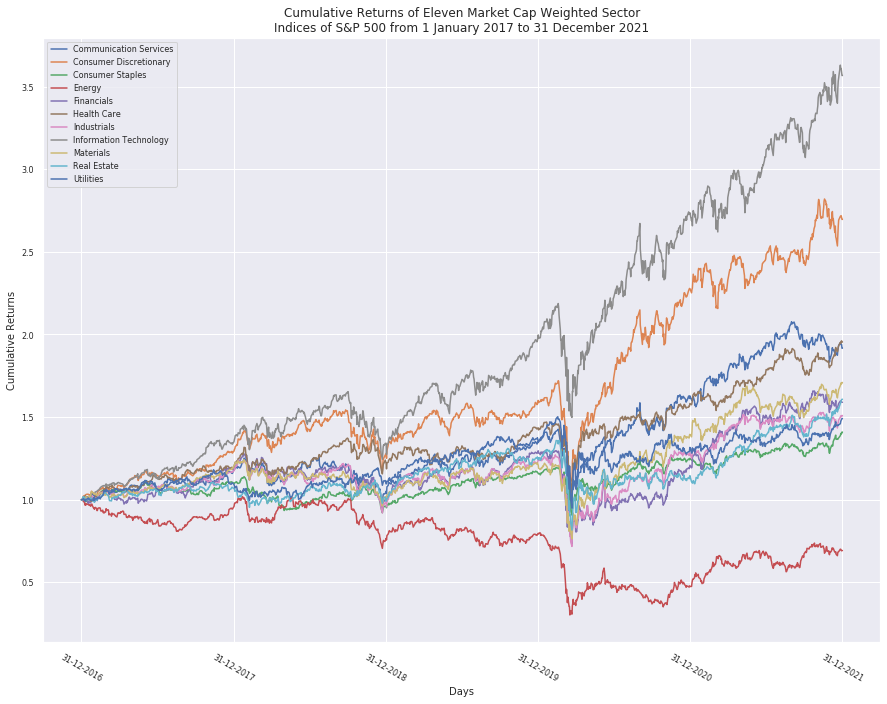

In [74]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.18)
for col, sector in enumerate(sector_11_indices.columns):
    plt.plot(np.asarray(np.cumprod(np.exp(sector_11_indices_array[:, col]))), label=sector)
plt.title(textwrap.fill('Cumulative Returns of Eleven Market Cap Weighted Sector Indices of S&P 500 from '
                        '1 January 2017 to 31 December 2021', 60),
          fontsize=12)
plt.legend(loc='best', fontsize=8)
plt.xticks([0, 365, 730, 1095, 1461, 1826],
           ['31-12-2016', '31-12-2017', '31-12-2018', '31-12-2019', '31-12-2020', '31-12-2021'],
           fontsize=8, rotation=-30)
plt.xlabel('Days', fontsize=10)
plt.ylabel('Cumulative Returns', fontsize=10)
plt.yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], ['0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5'], fontsize=8)
del sector, col
plt.show()

In [75]:
# construct portfolios
end_of_month_vector = np.asarray([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
                                  31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
                                  31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
                                  31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
                                  31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
end_of_month_vector_cumsum = np.cumsum(end_of_month_vector)
month_vector = np.asarray(['January', 'February', 'March', 'April', 'May', 'June',
                           'July', 'August', 'September', 'October', 'November', 'December'])
year_vector = np.asarray(['2017', '2018', '2019', '2020', '2021'])

# minimum variance portfolio
sector_11_indices_array = sector_11_indices_array[1:, :]

# how many months to consider when calculating realised covariance
months = 12

In [76]:
weight_matrix_maximum_sharpe_ratio = np.zeros_like(sector_11_indices_array)
weight_matrix_maximum_sharpe_ratio_restriction = np.zeros_like(sector_11_indices_array)

In [77]:
import sys
sys.path.append("..")
from CovRegpy_measures import cumulative_return
from CovRegpy_finance_utils import global_minimum_forward_applied_information, sharpe_forward_applied_information, \
global_minimum_forward_applied_information_long, sharpe_forward_applied_information_summation_restriction

In [78]:
# weights calculated on and used on different data (one month ahead)
for day in range(len(end_of_month_vector_cumsum[:-int(months + 1)])):
    
    # calculate annual covariance
    annual_covariance = \
        np.cov(sector_11_indices_array[
               end_of_month_vector_cumsum[int(day)]:end_of_month_vector_cumsum[int(day + months)], :].T)
    # calculate annual returns
    annual_returns = \
        np.sum(sector_11_indices_array[
               end_of_month_vector_cumsum[int(day)]:end_of_month_vector_cumsum[int(day + months)], :], axis=0)

    # calculate actual covariance and returns looking forward
    monthly_covariance = \
        np.cov(sector_11_indices_array[
               end_of_month_vector_cumsum[
                   int(day + months)]:end_of_month_vector_cumsum[int(day + months + 1)], :].T)
    # monthly returns are annualised
    monthly_returns = \
        np.sum(sector_11_indices_array[
               end_of_month_vector_cumsum[
                   int(day + months)]:end_of_month_vector_cumsum[int(day + months + 1)], :], axis=0) / \
        ((end_of_month_vector_cumsum[int(day + months + 1)] - end_of_month_vector_cumsum[int(day + months)]) /
         (end_of_month_vector_cumsum[int(day + months + 1)] - end_of_month_vector_cumsum[int(day + 1)]))
    
    # calculate global minimum variance portfolio
    gm_w, gm_sd, gm_r = global_minimum_forward_applied_information(annual_covariance, monthly_covariance,
                                                                   monthly_returns)
    # plt.scatter(gm_sd, gm_r, label='Global minimum variance portfolio', zorder=2)

    # calculate global minimum variance portfolio - long only
    gm_w_long, gm_sd_long, gm_r_long = global_minimum_forward_applied_information_long(annual_covariance,
                                                                                       monthly_covariance,
                                                                                       monthly_returns)
    # plt.scatter(gm_sd, gm_r, label='Global minimum variance portfolio', zorder=2)

    # calculate maximum sharpe ratio portfolio
    ms_w, ms_sd, ms_r = sharpe_forward_applied_information(annual_covariance, monthly_covariance, monthly_returns,
                                                           risk_free, gm_w, gm_r)
    # plt.scatter(ms_sd, ms_r, label='Maximum Sharpe ratio portfolio', zorder=2)

    # calculate maximum sharpe ratio portfolio
    msr_w, msr_sd, msr_r = sharpe_forward_applied_information_summation_restriction(annual_covariance,
                                                                                    monthly_covariance,
                                                                                    monthly_returns, risk_free,
                                                                                    gm_w, gm_r, short_limit=0.3,
                                                                                    long_limit=1.3)
    
    weight_matrix_maximum_sharpe_ratio[end_of_month_vector_cumsum[day]:end_of_month_vector_cumsum[int(day + 1)], :] = ms_w
    weight_matrix_maximum_sharpe_ratio_restriction[end_of_month_vector_cumsum[day]:end_of_month_vector_cumsum[int(day + 1)], :] = msr_w

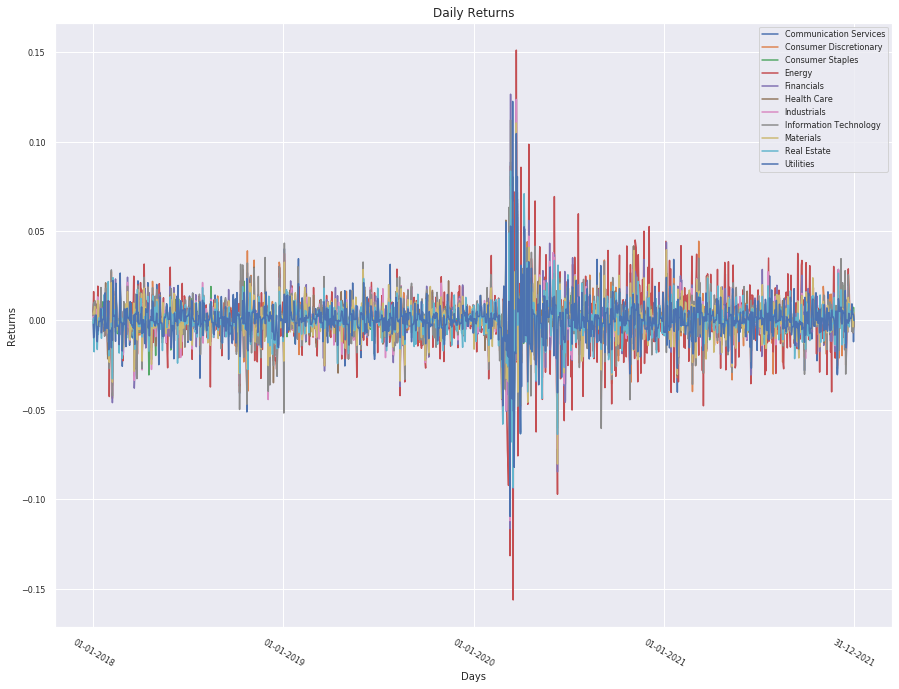

In [89]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.18)
plt.title('Daily Returns', fontsize=12)
for index in range(11):
    plt.plot(sector_11_indices_array[end_of_month_vector_cumsum[12]:].T[index, :], label=sector_11_indices.columns[index])
plt.yticks(fontsize=8)
plt.ylabel('Returns', fontsize=10)
plt.xticks([0, 365, 730, 1096, 1460],
           ['01-01-2018', '01-01-2019', '01-01-2020', '01-01-2021', '31-12-2021'],
           fontsize=8, rotation=-30)
plt.xlabel('Days', fontsize=10)
plt.legend(loc='best', fontsize=8)
plt.show()

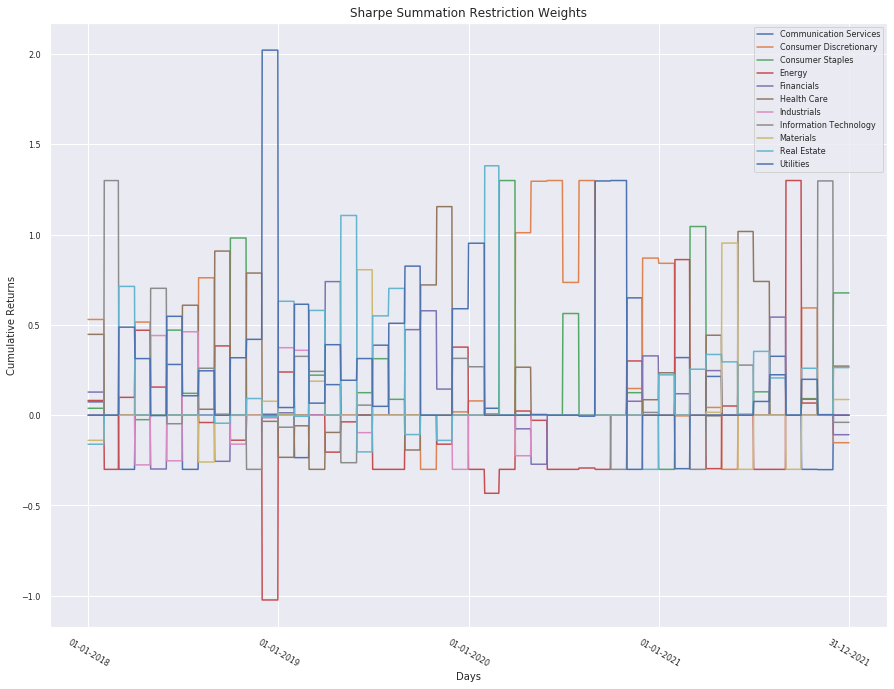

In [88]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.18)
plt.title('Sharpe Summation Restriction Weights', fontsize=12)
for index in range(11):
    plt.plot(weight_matrix_maximum_sharpe_ratio_restriction[:end_of_month_vector_cumsum[48]].T[index, :], label=sector_11_indices.columns[index])
plt.yticks(fontsize=8)
plt.ylabel('Weight Magnitudes', fontsize=10)
plt.xticks([0, 365, 730, 1096, 1460],
           ['01-01-2018', '01-01-2019', '01-01-2020', '01-01-2021', '31-12-2021'],
           fontsize=8, rotation=-30)
plt.xlabel('Days', fontsize=10)
plt.legend(loc='best', fontsize=8)
plt.show()

In [83]:
cumulative_returns_maximum_sharpe_ratio_portfolio = \
    cumulative_return(weight_matrix_maximum_sharpe_ratio[:end_of_month_vector_cumsum[48]].T,
                      sector_11_indices_array[end_of_month_vector_cumsum[12]:].T)
cumulative_returns_maximum_sharpe_ratio_portfolio_restriction = \
    cumulative_return(weight_matrix_maximum_sharpe_ratio_restriction[:end_of_month_vector_cumsum[48]].T,
                      sector_11_indices_array[end_of_month_vector_cumsum[12]:].T)

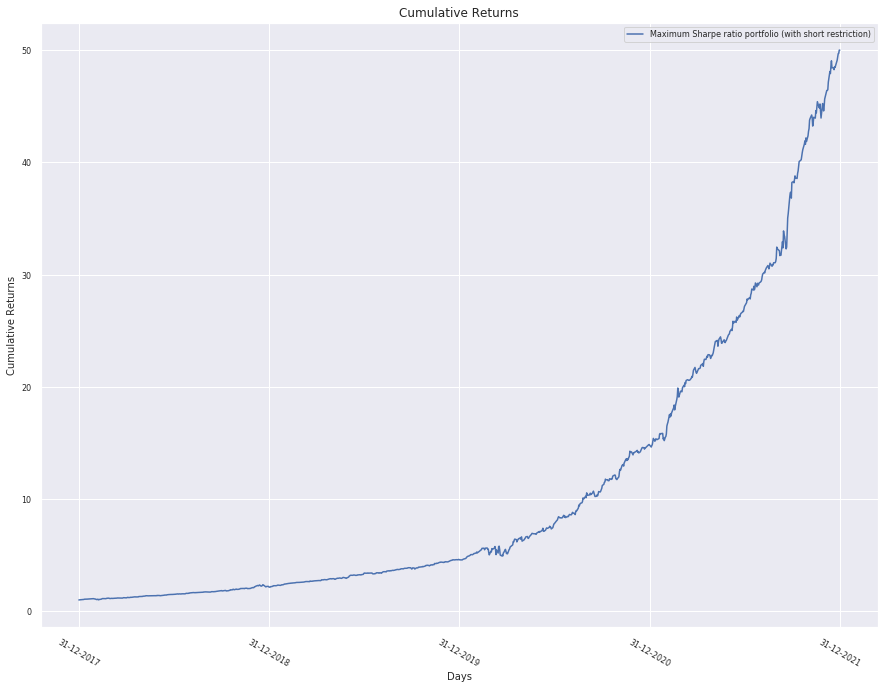

In [84]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.18)
plt.title('Cumulative Returns', fontsize=12)
# plt.plot(cumulative_returns_maximum_sharpe_ratio_portfolio, label='Maximum Sharpe ratio portfolio')
plt.plot(cumulative_returns_maximum_sharpe_ratio_portfolio_restriction, label='Maximum Sharpe ratio portfolio (with short restriction)')
plt.yticks(fontsize=8)
plt.ylabel('Cumulative Returns', fontsize=10)
plt.xticks([0, 365, 730, 1096, 1461],
           ['31-12-2017', '31-12-2018', '31-12-2019', '31-12-2020', '31-12-2021'],
           fontsize=8, rotation=-30)
plt.xlabel('Days', fontsize=10)
plt.legend(loc='best', fontsize=8)
plt.show()